# Quantum Binary Classifier using Parameterized Quantum Circuits (PQC)

This notebook implements a quantum binary classifier using Parameterized Quantum Circuits (PQC) with Qiskit.

## 1. Setup and Imports

In [8]:
# Import required libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler, Estimator

# Set random seeds
seed = 12345
algorithm_globals.random_seed = seed
np.random.seed(seed)

## 2. Data Preparation

In [9]:
# Generate and prepare dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=seed)

# Scale features to be between 0 and pi
X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * np.pi

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=seed
)

num_features = X_train.shape[1]

## 3. Quantum Circuit Components and Visualization

In [10]:
# Feature Map: Encodes classical data into quantum states
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='linear')

# Ansatz: The trainable part of the PQC
ansatz = RealAmplitudes(num_qubits=num_features, reps=3, entanglement='linear')

# Combine feature map and ansatz
pqc = QuantumCircuit(num_features)
pqc.compose(feature_map, inplace=True)
pqc.compose(ansatz, inplace=True)

### 3.1 Circuit Visualization
View the quantum circuits used in this classifier.

In [ ]:
# Visualize the quantum circuits
import matplotlib.pyplot as plt

# Plot feature map circuit
plt.figure(figsize=(12, 4))
feature_map.draw('mpl', style='iqx')
plt.title('Feature Map Circuit')
plt.show()

# Plot ansatz circuit
plt.figure(figsize=(12, 4))
ansatz.draw('mpl', style='iqx')
plt.title('Ansatz Circuit (Trainable Part)')
plt.show()

# Plot complete PQC
plt.figure(figsize=(15, 5))
pqc.draw('mpl', style='iqx')
plt.title('Complete Parameterized Quantum Circuit (PQC)')
plt.show()

## 4. Quantum Output and Cost Function

In [11]:
estimator = Estimator()

def get_quantum_output(data_point, parameters):
    """Executes the PQC and returns the expectation value of Z on the first qubit."""
    # Bind data to feature map parameters
    param_dict_fm = {fm_param: dp_val for fm_param, dp_val in zip(feature_map.parameters, data_point)}
    param_dict_ansatz = {ans_param: p_val for ans_param, p_val in zip(ansatz.parameters, parameters)}
    
    final_qc = pqc.assign_parameters({**param_dict_fm, **param_dict_ansatz})
    
    # Define the observable
    observable_str = "Z" + "I" * (num_features - 1)
    from qiskit.quantum_info import SparsePauliOp
    observable = SparsePauliOp(observable_str)
    
    # Calculate expectation value
    job = estimator.run([final_qc], [observable])
    result = job.result()
    expectation_value = result.values[0]
    
    return (expectation_value + 1) / 2.0

def cost_function(parameters):
    """Calculates the Mean Squared Error between predictions and true labels."""
    predictions = [get_quantum_output(x, parameters) for x in X_train]
    cost = np.mean((y_train - predictions) ** 2)
    if cost_function.iter % 10 == 0:
        print(f"Iteration {cost_function.iter}, Cost: {cost:.4f}")
    cost_function.iter += 1
    return cost

cost_function.iter = 0

## 5. Training

In [12]:
# Initialize and optimize
initial_parameters = np.random.random(ansatz.num_parameters)
optimizer = COBYLA(maxiter=100)

print("Starting training...")
opt_result = optimizer.minimize(fun=cost_function, x0=initial_parameters)

optimized_parameters = opt_result.x
print("Training complete.")
print(f"Optimized Parameters: {optimized_parameters}")
print(f"Final cost: {opt_result.fun:.4f}")

Starting training...
Iteration 0, Cost: 0.3047
Iteration 10, Cost: 0.2680
Iteration 10, Cost: 0.2680
Iteration 20, Cost: 0.2207
Iteration 20, Cost: 0.2207
Iteration 30, Cost: 0.2138
Iteration 30, Cost: 0.2138
Iteration 40, Cost: 0.2111
Iteration 40, Cost: 0.2111
Iteration 50, Cost: 0.2091
Iteration 50, Cost: 0.2091
Iteration 60, Cost: 0.2065
Iteration 60, Cost: 0.2065
Iteration 70, Cost: 0.2050
Iteration 70, Cost: 0.2050
Iteration 80, Cost: 0.2040
Iteration 80, Cost: 0.2040
Iteration 90, Cost: 0.2033
Iteration 90, Cost: 0.2033
Training complete.
Optimized Parameters: [ 0.84722524  0.84970567 -0.98023731  1.2061315  -0.55152138  0.59036674
  0.74531147  0.17253754]
Final cost: 0.2033
Training complete.
Optimized Parameters: [ 0.84722524  0.84970567 -0.98023731  1.2061315  -0.55152138  0.59036674
  0.74531147  0.17253754]
Final cost: 0.2033


## 6. Evaluation

In [ ]:
def predict(data, parameters):
    """Makes predictions for a given dataset using the trained parameters."""
    quantum_outputs = [get_quantum_output(x, parameters) for x in data]
    return (np.array(quantum_outputs) > 0.5).astype(int)

# Evaluate on test and training sets
y_pred_test = predict(X_test, optimized_parameters)
y_pred_train = predict(X_train, optimized_parameters)

# Calculate accuracies
accuracy = np.mean(y_pred_test == y_test)
train_accuracy = np.mean(y_pred_train == y_train)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate confusion matrices
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot test set confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Class 0', 'Class 1'])
disp_test.plot(ax=ax1, cmap='Blues')
ax1.set_title('Test Set Confusion Matrix')

# Plot training set confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Class 0', 'Class 1'])
disp_train.plot(ax=ax2, cmap='Blues')
ax2.set_title('Training Set Confusion Matrix')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nConfusion Matrix Analysis:")
print("Test Set:")
print(f"True Negatives: {cm_test[0,0]}")
print(f"False Positives: {cm_test[0,1]}")
print(f"False Negatives: {cm_test[1,0]}")
print(f"True Positives: {cm_test[1,1]}")

print("\nTraining Set:")
print(f"True Negatives: {cm_train[0,0]}")
print(f"False Positives: {cm_train[0,1]}")
print(f"False Negatives: {cm_train[1,0]}")
print(f"True Positives: {cm_train[1,1]}")

Test Accuracy: 73.33%
Train Accuracy: 72.86%


## 7. Visualization of Results


Attempting to plot decision boundary...


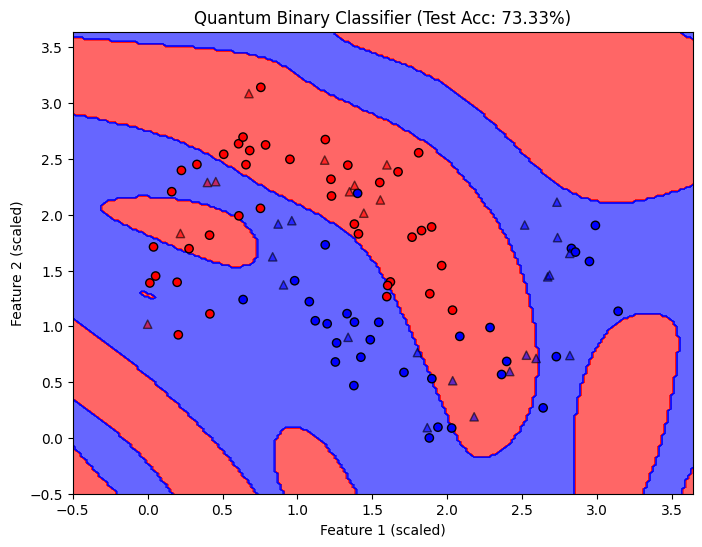

In [14]:
try:
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    
    print("\nAttempting to plot decision boundary...")
    
    # Create mesh for plotting
    h = .02
    x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
    y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Generate predictions
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(mesh_data, optimized_parameters)
    Z = Z.reshape(xx.shape)
    
    # Create plot
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cm_bright, alpha=0.6)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k', alpha=0.6, marker='^')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Quantum Binary Classifier (Test Acc: {accuracy*100:.2f}%)")
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()
except ImportError:
    print("Matplotlib not found. Skipping decision boundary plot.")
except Exception as e:
    print(f"Error during plotting: {e}. Skipping decision boundary plot.")